<u><b><h1 align="center" style = "color:Red; background-color:yellow;" > Data Science Regression Project: Predicting Home Prices in Banglore </h1></b></u>

<u><b><h2 style = "color:Blue"> Loading Data</h2></b></u>

In [524]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

In [525]:
df1 = pd.read_csv("Bengaluru_House_Data.csv")
print(df1.shape)
df1.head()

(13320, 9)


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [526]:
df1["area_type"].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [527]:
df1['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

<b> Dropping features that are not required to build our model </b>

In [528]:
df2 = df1.drop(["area_type", "availability", "society", "balcony"], axis = "columns")
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


<u><b><h2 style = "color:Blue;">Data Cleaning</h2></b></u>

In [529]:

df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [530]:
df3 = df2.dropna()  # Since the NaN values in each column were very few as compared to total rows in the dataset ; hence we can easily drop those rows.
df3.shape

(13246, 5)

In [531]:
df3["size"].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

Now it's evident that the BHK and Bedroom are one and all the same thing ; but since the string value is different hence they are treated different ; for that purpose we can make a column named "Size_in_BHK".
For that make a function that retrieve the Integer value from the size column.

<b> Add new feature(integer) for bhk (Bedrooms Hall Kitchen) </b>

In [532]:
df3['Size_in_BHK'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.head()

C:\Users\asus\AppData\Local\Temp\ipykernel_15636\14335771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Size_in_BHK'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


,location,size,total_sqft,bath,price,Size_in_BHK
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [533]:
df3.drop(["size"], axis = "columns", inplace=True)

C:\Users\asus\AppData\Local\Temp\ipykernel_15636\1760941547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop(["size"], axis = "columns", inplace=True)


In [534]:
df3["total_sqft"].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

Check that the values are not one having single number  ; few datas of <b>total_sqft</b> have ranges too ; like 1133-1384. 
We need to remove these. 
<br>For this we can check if the total_sqft value is float or not.

In [535]:
def is_float(x):
    try:
        float(x)   # If float value exists then it'll return ; as the range can't be converted to float value.
    except:
        return False
    return True

In [536]:
df3[df3["total_sqft"].apply(is_float)]     # Checking for valid numerical value of "total_sqft"

,location,total_sqft,bath,price,Size_in_BHK
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2
...,...,...,...,...,...
13315,Whitefield,3453,4.0,231.00,5
13316,Richards Town,3600,5.0,400.00,4
13317,Raja Rajeshwari Nagar,1141,2.0,60.00,2
13318,Padmanabhanagar,4689,4.0,488.00,4


In [537]:
df3[~df3["total_sqft"].apply(is_float)].head(15) # Negation used here ; will throw dataset where the "total_sqft" value is range type

,location,total_sqft,bath,price,Size_in_BHK
30,Yelahanka,2100 - 2850,4.0,186.000,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2
410,Kengeri,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,1195 - 1440,2.0,63.770,2
648,Arekere,4125Perch,9.0,265.000,9
661,Yelahanka,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,3090 - 5002,4.0,445.000,4


Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion.We will just drop such corner cases to keep things simple.

In [538]:
# Function to convert ranges to number (We will take average of upper limit and lower limit)

def range_sqft_to_num (x):
    tokens = x.split("-")
    if(len(tokens)==2):
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [539]:
df4 = df3.copy()
df4.total_sqft = df4["total_sqft"].apply(range_sqft_to_num)

# Now we will drop NaN values of total_sqft column which we had converted to NaN by changing the extra values like 34.46 sq. meter etc. to NaN 

df4.dropna(subset = ["total_sqft"], inplace=True)   # we could also use this command :  df4 = df4[df4.total_sqft.notnull()]
print(df4.shape)
df4.head(15)

(13200, 5)


,location,total_sqft,bath,price,Size_in_BHK
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2
5,Whitefield,1170.0,2.0,38.00,2
6,Old Airport Road,2732.0,4.0,204.00,4
7,Rajaji Nagar,3300.0,4.0,600.00,4
8,Marathahalli,1310.0,3.0,63.25,3
9,Gandhi Bazar,1020.0,6.0,370.00,6


We have reduced the no. of rows to 13200 which were 13320 in the original dataset. 

<u><b><h2 style = "color:Blue;">Feature Engineering</h2></b></u>

In [540]:
# Adding new feature "Price_per_sqft" 
df5 = df4.copy()
df5["Price_per_sqft"] = df5["price"]*100000/df5["total_sqft"]
df5.head()

,location,total_sqft,bath,price,Size_in_BHK,Price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [541]:
# Calculating the above dataframe's data analysis 
df5_stats = df5['Price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: Price_per_sqft, dtype: float64

In [542]:
len(df5.location.unique())

1298

<b> Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations.</b>

The no. of unique locations are huge which are 1298 ; and hence encoding won't be suitable here.


In [543]:
df5.location.apply(lambda x : x.strip())  # This method is used  trim leading and trailing spaces
location_count = df5.location.value_counts(ascending=False)
location_count

location
Whitefield                   532
Sarjapur  Road               392
Electronic City              302
Kanakpura Road               264
Thanisandra                  232
                            ... 
Indiranagar HAL 2nd Stage      1
Maruthi HBCS Layout            1
K R C kothanur                 1
1Channasandra                  1
Abshot Layout                  1
Name: count, Length: 1298, dtype: int64

<u><b><h2 style = "color:Blue;">Dimensionality Reduction</h2></b></u>

In [544]:
print(len(location_count[location_count > 10]))
print(len(location_count[location_count <= 10]))

240
1058


It's clearly evident that only few locations, precisely 240 have location count greater than 10.
While 1058 locations are such that which have occurence less than or equal to 10 in the dataset.


<b>Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns.</b>

In [545]:
location_count_less_than_10 = location_count[location_count <= 10]

In [546]:
df5.location = df5.location.apply(lambda x : "others" if x in location_count_less_than_10 else x)
df5.head()

,location,total_sqft,bath,price,Size_in_BHK,Price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [547]:
len(df5.location.unique())   # Only 241 unique values left now ; hence one hot encoding will be suitable here.

241

<u><b><h2 style = "color:Blue;">Outlier Removal Using Business Logic</h2></b></u>

<b><h4 style="color:green;">Size Outlier Removal</h4></b>

<b>normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft</b>

In [548]:
df5[(df5["total_sqft"]/df5["Size_in_BHK"])<300]

,location,total_sqft,bath,price,Size_in_BHK,Price_per_sqft
9,others,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,1407.0,4.0,150.0,6,10660.980810
68,others,1350.0,7.0,85.0,8,6296.296296
70,others,500.0,3.0,100.0,3,20000.000000
...,...,...,...,...,...,...
13277,others,1400.0,7.0,218.0,7,15571.428571
13279,others,1200.0,5.0,130.0,6,10833.333333
13281,Margondanahalli,1375.0,5.0,125.0,5,9090.909091
13303,Vidyaranyapura,774.0,5.0,70.0,5,9043.927649


In [549]:
df6 = df5[~((df5["total_sqft"]/df5["Size_in_BHK"])<300)]    # storing only relevant data into df6
df6.shape

(12456, 6)

<b><h4 style="color:green;">Price Per Sqft Outlier Removal : Using Standard Deviation and Mean</h4></b>

In [550]:
df6["Price_per_sqft"].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: Price_per_sqft, dtype: float64

Now we can check that the datasset contains few values of Price Per Sqft. to be as low as INR 267 which is quite impossible ; same with the price to be INR 176470, 
now this might be possible for some specific posh or luxury area but this is not relevant for our basic generic model.<br>
Hence we need to ignore these values and keep only generic dataset which have fair price per sqft.

Since the data should be normally distributed. For this we can use the statistical method which says the range such data should be in range[mean-std , mean+std]

In [551]:
# Let's create a function for Outlier Removal

def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        mean= np.mean(subdf["Price_per_sqft"])
        std = np.std(subdf["Price_per_sqft"])
        reduced_df = subdf[(subdf.Price_per_sqft >= mean-std) & (subdf.Price_per_sqft <= mean+std)]
        df_out = pd.concat([df_out, reduced_df],ignore_index=True)
    return df_out

In [552]:
df7 = remove_pps_outliers(df6)
df7.shape

(10245, 6)

<b> Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like </b>

In [553]:
def plot_scatter_pps(df, given_location):
    bhk_2 = df[(df.location == given_location) & (df.Size_in_BHK==2)]
    bhk_3 = df[(df.location == given_location) & (df.Size_in_BHK==3)]
    matplotlib.rcParams['figure.figsize'] = (12,7)
    plt.scatter(bhk_2.total_sqft, bhk_2.price, color="blue", label = "2 BHK", s=50)
    plt.scatter(bhk_3.total_sqft,bhk_3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area", fontsize=13, color="darkslategray", fontweight=1000, loc="center", labelpad=20)
    plt.ylabel("Price (Lakh Indian Rupees)", fontsize=13, color="darkslategray", fontweight=1000 , loc="center", labelpad=20)
    plt.title(given_location, pad=20, size=15)
    plt.legend()

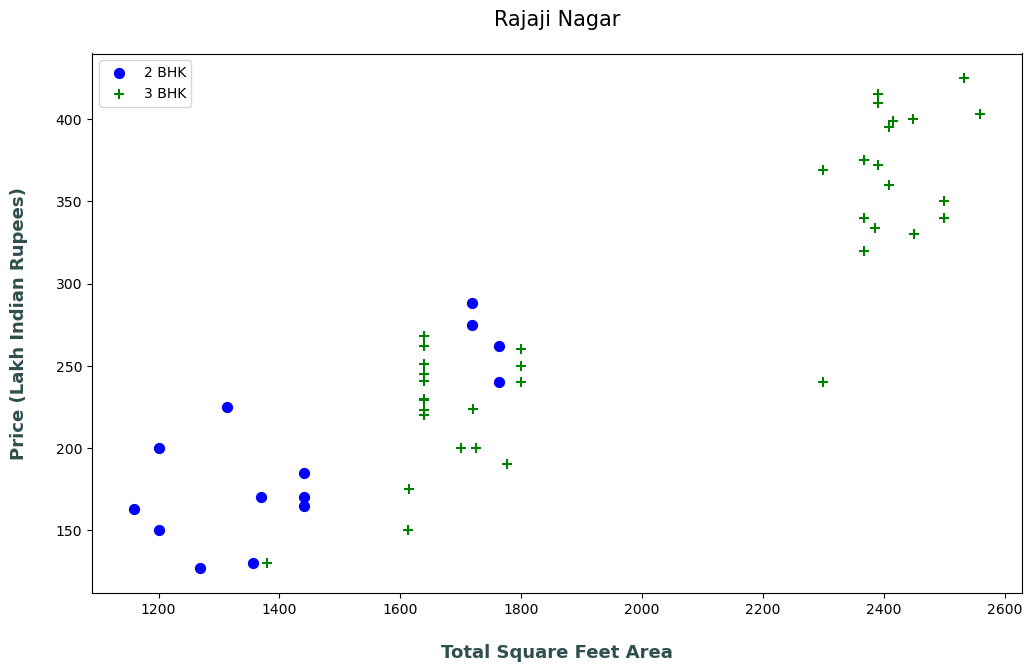

In [554]:
plot_scatter_pps(df7, "Rajaji Nagar")

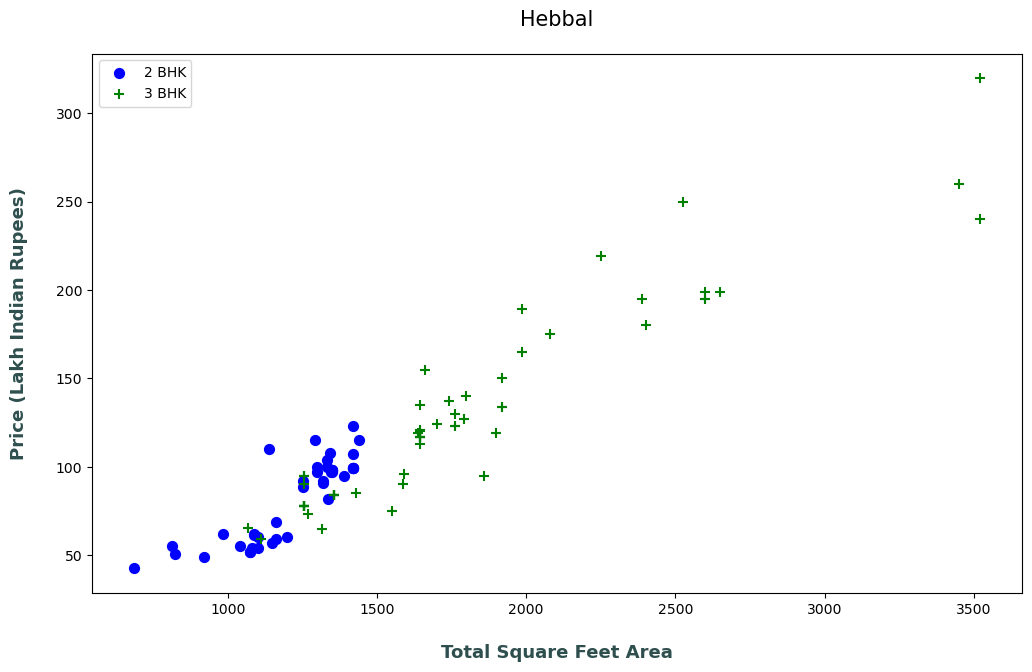

In [555]:
plot_scatter_pps(df7,"Hebbal")

<b>Now it's evident that for a particular location , their are some cases where the price for 2 BHK is more than that of 3 BHK when the size of property is same.
<br>For example , For Rajaji Nagar for size 1700-1800 sqft ; the price of 2BHK is more than 3 BHK, which is not appropriate or not genric.
<br>Hence we need to remove these data set.</b> 

<b><h4 style = "color:green;">Removing the Price Outliers</h4><b>

In [556]:
# Making a function to remove such outlier 

def remove_bhk_price_outlier(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby("location"):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby("Size_in_BHK"):
            bhk_stats[bhk] = {
                "mean" : np.mean(bhk_df["Price_per_sqft"]),
                "std" : np.std(bhk_df["Price_per_sqft"]), 
                "count" : bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('Size_in_BHK'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.Price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df8 = remove_bhk_price_outlier(df7)
df8.shape

(7331, 6)

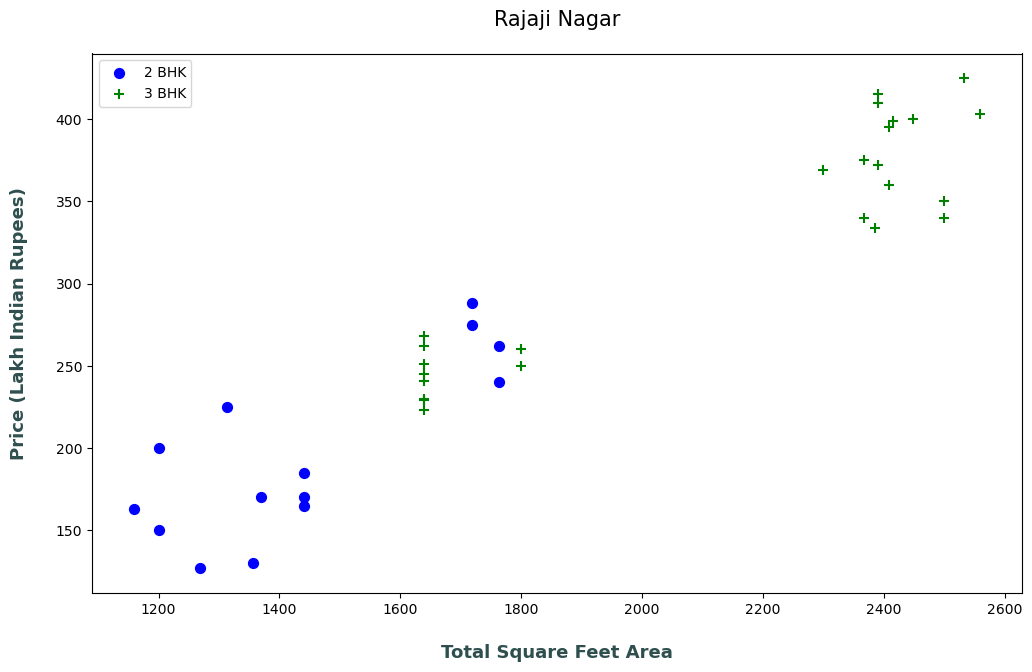

In [557]:
plot_scatter_pps(df8, "Rajaji Nagar")

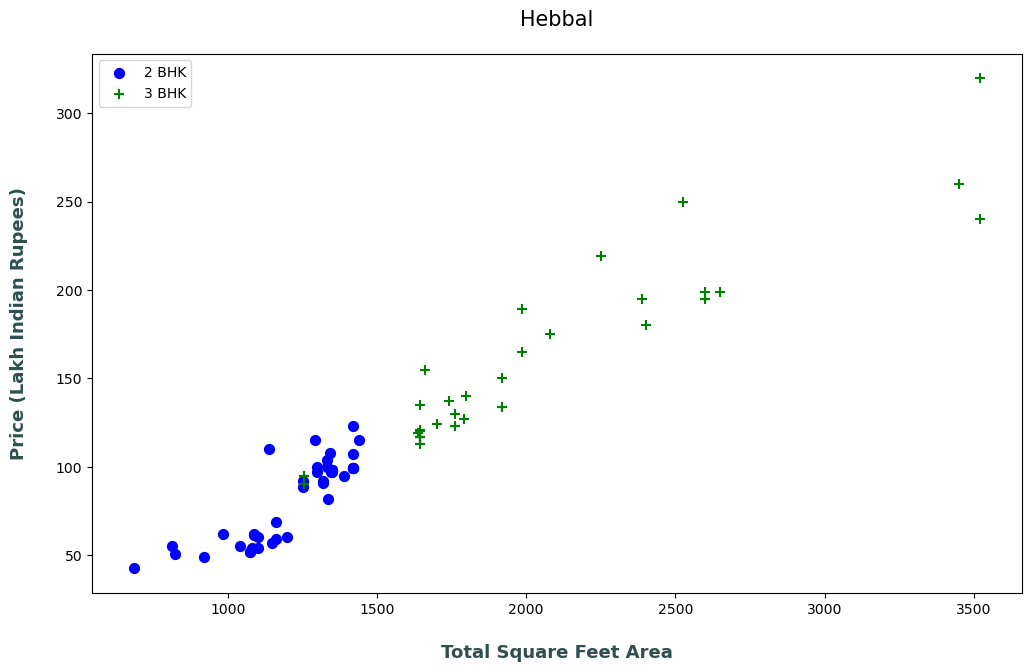

In [558]:
plot_scatter_pps(df8, "Hebbal")

<b><h4>Let's compare the before and after outlier removal results.</h4></b>

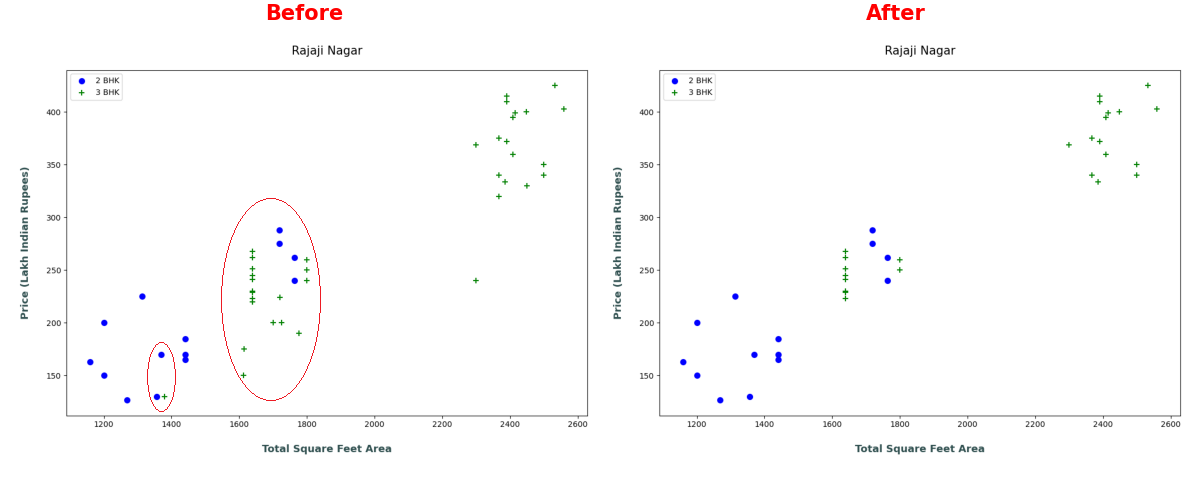

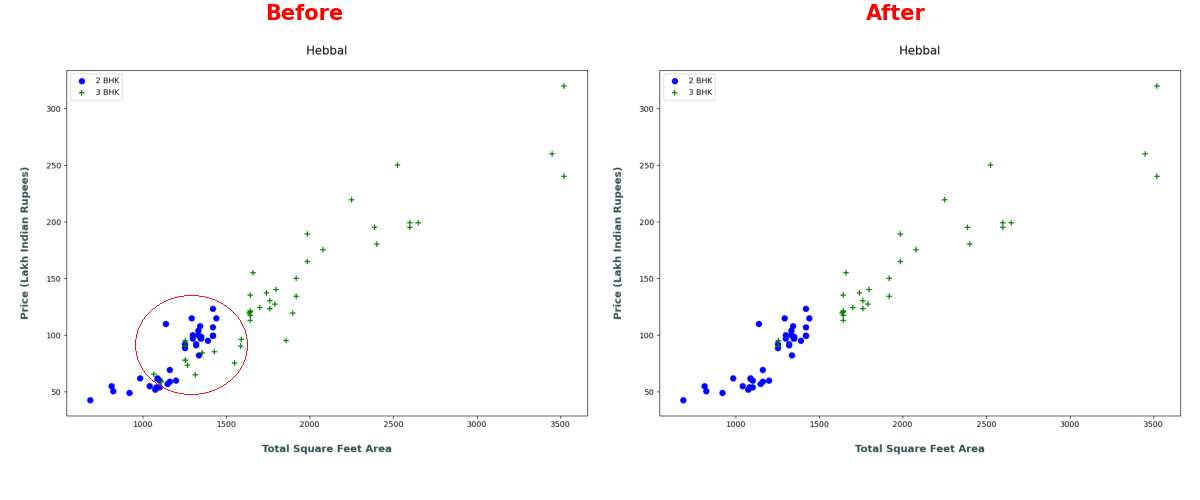

Text(0, 0.5, 'Count')

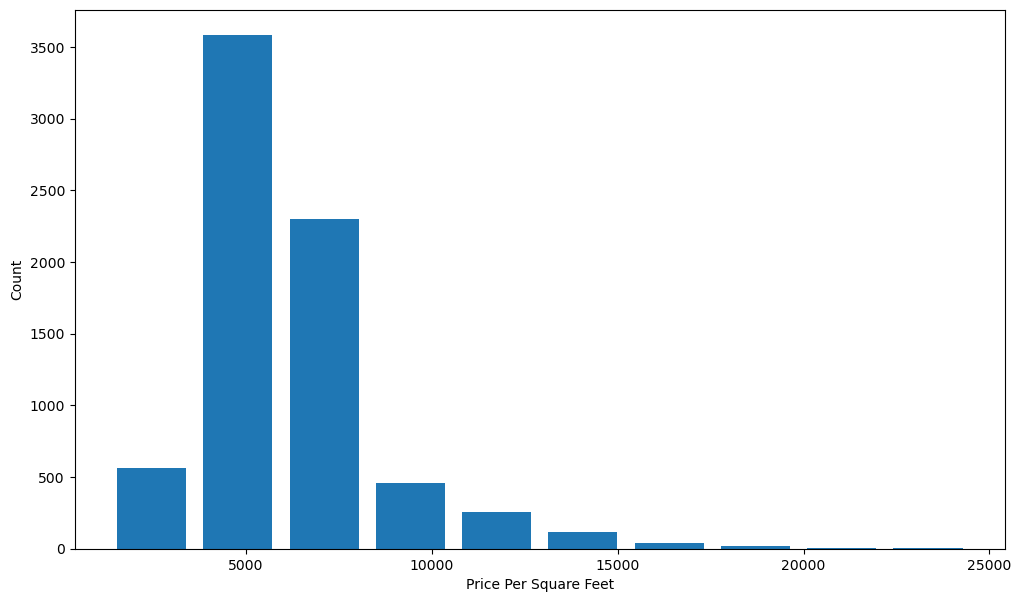

In [559]:
# Depicting the normal distribution 
import matplotlib
matplotlib.rcParams["figure.figsize"] = (12,7)
plt.hist(df8.Price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<b><h4 style = "color:green;">Removing the Bathroom Feature Outliers</h4><b>

In [560]:
df8.bath.unique()

array([ 2.,  3.,  4.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

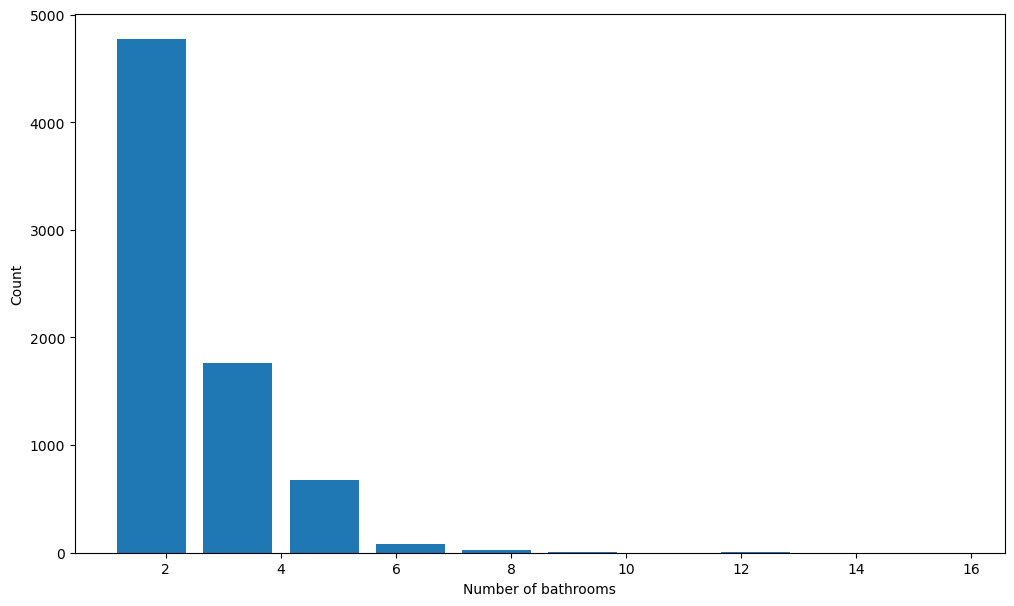

In [561]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [562]:
df8[df8.bath>10]

,location,total_sqft,bath,price,Size_in_BHK,Price_per_sqft
5271,Neeladri Nagar,4000.0,12.0,160.0,10,4000.000000
8478,others,12000.0,12.0,525.0,10,4375.000000
8567,others,10000.0,16.0,550.0,16,5500.000000
9307,others,6000.0,12.0,150.0,11,2500.000000
9639,others,5425.0,13.0,275.0,13,5069.124424


<b>It is unusual to have 2 more bathrooms than number of bedrooms in a home</b>

In [563]:
df9 = df8[df8.bath<df8.Size_in_BHK+2]
df9.head()

,location,total_sqft,bath,price,Size_in_BHK,Price_per_sqft
1,Devarachikkanahalli,1250.0,2.0,40.0,2,3200.000000
2,Devarachikkanahalli,1200.0,2.0,83.0,2,6916.666667
3,Devarachikkanahalli,1170.0,2.0,40.0,2,3418.803419
4,Devarachikkanahalli,1425.0,2.0,65.0,3,4561.403509
5,Devarachikkanahalli,947.0,2.0,43.0,2,4540.654699


<b>Now since the whole dataset has been refined ; and there is no need of Price_per_sqft we can drop it</b>

In [564]:
df10 = df9.drop("Price_per_sqft", axis="columns")
df10.head()

,location,total_sqft,bath,price,Size_in_BHK
1,Devarachikkanahalli,1250.0,2.0,40.0,2
2,Devarachikkanahalli,1200.0,2.0,83.0,2
3,Devarachikkanahalli,1170.0,2.0,40.0,2
4,Devarachikkanahalli,1425.0,2.0,65.0,3
5,Devarachikkanahalli,947.0,2.0,43.0,2
